In [23]:
#import libraries
from bw_temporalis import easy_timedelta_distribution, TemporalDistribution
from edge_extractor import EdgeExtracter
from medusa_tools import *
import bw2data as bd
import bw2calc as bc
import numpy as np
import pandas as pd


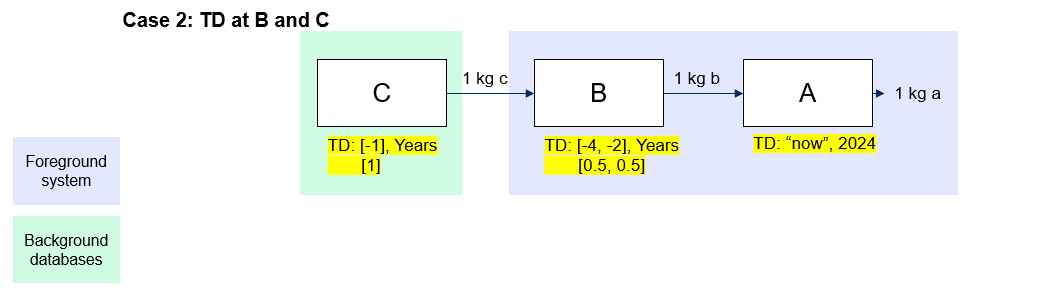

In [24]:
#setup example
bd.projects.set_current("test_abc")


In [25]:
bd.Database('temporalis-bio').write({
    ('temporalis-bio', "CO2"): {
        "type": "emission",
        "name": "carbon dioxide",
        "temporalis code": "co2",
    },
    ('temporalis-bio', "CH4"): {
        "type": "emission",
        "name": "methane",
        "temporalis code": "ch4",
    },
})

bd.Database('background_2022').write({
    ('background_2022', 'C'): {
    'name': 'process C',
    'exchanges': [
            {
                'amount': 1,
                'type': 'production',
                'input': ('background_2022', 'C'),
            },
            {
                'amount': 1,
                'type': 'biosphere',
                'input': ('temporalis-bio', 'CO2'),
            },  ]},
},

        )

bd.Database('background_2020').write({
    ('background_2020', 'C'): {
    'name': 'process C',
    'exchanges': [
            {
                'amount': 1,
                'type': 'production',
                'input': ('background_2020', 'C'),
            },
            {
                'amount': 2,
                'type': 'biosphere',
                'input': ('temporalis-bio', 'CO2'),
            },  ]},
},

        )

bd.Database('foreground').write({
    ('foreground', 'A'): {
        'name': 'process A',
        'exchanges': [
            {
                'amount': 1,
                'type': 'production',
                'input': ('foreground', 'A'),
            },
            {
                'amount': 1,
                'type': 'technosphere',
                'input': ('foreground', 'B'),
                'temporal_distribution': TemporalDistribution(
                    np.array([-4, -2], dtype='timedelta64[Y]'),
                    np.array([0.5, 0.5])),  
            },
        ]
    },
    ('foreground', 'B'):
    {
        "name": "process B",
        "exchanges": [
             {
                'amount': 1,
                'type': 'technosphere',
                'input': ('background_2022', 'C'),
                'temporal_distribution': TemporalDistribution(
                    np.array([-1], dtype='timedelta64[Y]'),
                    np.array([1])), 
              }
        ]

    },
})

100%|██████████| 2/2 [00:00<?, ?it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<?, ?it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 1/1 [00:00<?, ?it/s]


Vacuuming database 
Not able to determine geocollections for all datasets. This database is not ready for regionalization.


100%|██████████| 2/2 [00:00<?, ?it/s]

Vacuuming database 


In [26]:
for act in bd.Database("foreground"):
    print(act)
    if "temporal_distribution" in act:
        print(act["temporal_distribution"].amount)
        print(act["temporal_distribution"].date)
        

for act in bd.Database("background_2022"):
    print(act)
    if "temporal_distribution" in act:
        print(act["temporal_distribution"].amount)
        print(act["temporal_distribution"].date)

'process B' (None, None, None)
'process A' (None, None, None)
'process C' (None, None, None)


The TD on the exchange between B and A is not stored at the activity (see print above) but at the level of exchanges (see print below)

In [27]:
for act in bd.Database("foreground"):
    for exc in act.exchanges():
        if "temporal_distribution" in exc:
            print(act)
            print(f"There is a temporal information for {exc}")
            print(exc["temporal_distribution"].amount)
            print(exc["temporal_distribution"].date)

'process B' (None, None, None)
There is a temporal information for Exchange: 1 None 'process C' (None, None, None) to 'process B' (None, None, None)>
[1.]
[-31556952]
'process A' (None, None, None)
There is a temporal information for Exchange: 1 None 'process B' (None, None, None) to 'process A' (None, None, None)>
[0.5 0.5]
[-126227808  -63113904]


In [28]:
bd.Method(("GWP", "example")).write([
    (('temporalis-bio', "CO2"), 1),
    (('temporalis-bio', "CH4"), 25),
])

In [29]:
demand = {('foreground', 'A'): 1}
gwp = ('GWP', 'example')

In [30]:
slca = bc.LCA(demand, gwp)
slca.lci()
slca.lcia()
print(f'Static LCA score: {slca.score}')

Static LCA score: 1.0


Medusa LCA

In [31]:
SKIPPABLE = [] #node.id for node in bd.Database('background_2020')] #+ [
    #node.id for node in bd.Database('background_2022')
#]

def filter_function(database_id: int) -> bool:
    return database_id in SKIPPABLE

In [32]:
eelca = EdgeExtracter(slca, edge_filter_function=filter_function)
timeline = eelca.build_edge_timeline()
timeline


Starting graph traversal
Calculation count: 2


[Edge(distribution=TemporalDistribution instance with 1 values and total: 1, leaf=False, consumer=-1, producer=161),
 Edge(distribution=TemporalDistribution instance with 2 values and total: 1, leaf=False, consumer=161, producer=162),
 Edge(distribution=TemporalDistribution instance with 2 values and total: 1, leaf=False, consumer=162, producer=159)]

In [33]:
database_date_dict = {
            datetime.strptime("2022", "%Y"): 'background_2022',
            datetime.strptime("2020", "%Y"): 'background_2020',
        }
print(database_date_dict.keys())
timeline_df = create_grouped_edge_dataframe(timeline, database_date_dict.keys(), interpolation_type="linear")
timeline_df

dict_keys([datetime.datetime(2022, 1, 1, 0, 0), datetime.datetime(2020, 1, 1, 0, 0)])


,date,year,producer,producer_name,consumer,consumer_name,amount,interpolation_weights
0,2019-01-01,2019,159,process C,162,process B,0.5,{2020: 1}
1,2020-01-01,2020,162,process B,161,process A,0.5,{2020: 1}
2,2021-01-01,2021,159,process C,162,process B,0.5,"{2020: 0.4993160054719562, 2022: 0.50068399452..."
3,2022-01-01,2022,162,process B,161,process A,0.5,{2022: 1}
4,2024-01-01,2024,161,process A,-1,-1,1.0,{2022: 1}


In [34]:
demand_timing_dict = create_demand_timing_dict(timeline_df, demand)

dp = create_datapackage_from_edge_timeline(timeline_df, database_date_dict, demand_timing_dict)

In [35]:
fu, data_objs, remapping = prepare_medusa_lca_inputs(demand=demand, demand_timing_dict=demand_timing_dict, method=gwp) 
lca = bc.LCA(fu, data_objs = data_objs + [dp], remapping_dicts=remapping)
lca.lci()
lca.lcia()
lca.score

0.0

### Investigation of matrices

In [36]:
lca.technosphere_matrix.toarray()

array([[ 1.        ,  0.        ,  0.        , -1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.50068399,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -1.        ,
         0.        , -0.49931601,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.      

In [38]:
df= pd.DataFrame(lca.technosphere_matrix.toarray()) #for excel visualization
df.to_csv("test.csv", index=False)

In [39]:
lca.load_lci_data(nonsquare_ok=True)

In [40]:
set(lca.dicts.activity.reversed.items())

{(0, 159),
 (1, 160),
 (2, 161),
 (3, 162),
 (4, 159002019),
 (5, 159002021),
 (6, 161002020),
 (7, 161002022),
 (8, 161002024),
 (9, 162002019),
 (10, 162002020),
 (11, 162002021),
 (12, 162002022)}

In [41]:
second_items_list = [item[1] for item in lca.dicts.activity.reversed.items()]
second_items_list

[159,
 160,
 161,
 162,
 159002019,
 159002021,
 161002020,
 161002022,
 161002024,
 162002019,
 162002020,
 162002021,
 162002022]

In [42]:
print("product_dict (mapping between Ids and csr_matrix column index):\n", lca.product_dict)
print("\nactivity_dict (mapping between IDS and csr_matrix row index):\n", lca.activity_dict)

product_dict (mapping between Ids and csr_matrix column index):
 {159: 0, 160: 1, 161: 2, 162: 3, 159002019: 4, 159002021: 5, 161002020: 6, 161002022: 7, 161002024: 8, 162002019: 9, 162002020: 10, 162002021: 11, 162002022: 12}

activity_dict (mapping between IDS and csr_matrix row index):
 {159: 0, 160: 1, 161: 2, 162: 3, 159002019: 4, 159002021: 5, 161002020: 6, 161002022: 7, 161002024: 8, 162002019: 9, 162002020: 10, 162002021: 11, 162002022: 12}


In [44]:
for key in lca.activity_dict:
    print(key, "->",bd.get_activity(key), bd.get_activity(key)["database"]) #BW does not find the "exploded nodes", because they exist only in the datapackages?

159 -> 'process C' (None, None, None) background_2022
160 -> 'process C' (None, None, None) background_2020
161 -> 'process A' (None, None, None) foreground
162 -> 'process B' (None, None, None) foreground


UnknownObject: 

In [45]:
f=lca.demand_array
f

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.])

In [46]:
lca.technosphere_matrix.toarray()

array([[ 1.        ,  0.        ,  0.        , -1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , -0.50068399,  0.        ],
       [ 0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -1.        ,
         0.        , -0.49931601,  0.        ],
       [ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        , -1.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.      

In [47]:
A_inv= np.linalg.inv(lca.technosphere_matrix.toarray())
A_inv

array([[1.        , 0.        , 1.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.50068399, 0.        ],
       [0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.49931601, 0.        ],
       [0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        , 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 1.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        , 0.     

In [48]:
s= np.matmul(A_inv, f)
s

array([0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. , 0. , 0.5, 0. , 0.5])

In [49]:
lca.biosphere_matrix.toarray()

array([[1., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [50]:
b= np.matmul(lca.biosphere_matrix.toarray(), s)
b

array([0.])